In [24]:
import numpy as np
import torch
import torchvision
from glob import glob
import os
from datetime import datetime

import src.wnet as wnet

device = 'mps'

In [25]:
# Construct Dataset
class BSDS500_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        self.image_paths = glob(os.path.join(root_dir, 'BSDS500', 'data', 'images', subset, '*.jpg'))
        self.image_size = (224, 224)
        
        self.max_image = None
        self.min_image = None
        for i in range(self.__len__()):
            image = torchvision.io.read_image(self.image_paths[i]).float()
            image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            self.max_image = torch.max(self.max_image, image) if self.max_image is not None else image
            self.min_image = torch.min(self.min_image, image) if self.min_image is not None else image

    def __len__(self):
        return len(self.image_paths)

    def size(self, idx=None):
        s = [self.__len__(), 3, self.image_size[0], self.image_size[1]]
        if idx is not None:
            s = s[idx]
        else:
            s = torch.Size(s)
        return s

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = torchvision.io.read_image(img_path)
        image = image.float()
        image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
        image = (image - self.min_image) / (self.max_image - self.min_image)
        return image.to(device)

class BSDS500():
    def __init__(self, root_dir, batch_size):
        self.trainset = BSDS500_dataset(root_dir, 'train')
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.valset = BSDS500_dataset(root_dir, 'val')
        self.valloader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=False)
        self.testset = BSDS500_dataset(root_dir, 'test')
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size, shuffle=False)

    def get_trainloader(self):
        return self.trainloader
    
    def get_valloader(self):
        return self.valloader

    def get_testloader(self):
        return self.testloader

dataset = BSDS500('../BSDS500', 16)
X_train = dataset.get_trainloader()
y_train = dataset.get_trainloader()
X_val = dataset.get_valloader()
y_val = dataset.get_valloader()
X_test = dataset.get_testloader()
y_test = dataset.get_testloader()

  VAL: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


EPOCH:      1
Train loss: 5.9076E-02
Valid loss: 4.3955E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


EPOCH:      2
Train loss: 4.2415E-02
Valid loss: 3.8968E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


EPOCH:      3
Train loss: 3.8727E-02
Valid loss: 3.8409E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


EPOCH:      4
Train loss: 3.7116E-02
Valid loss: 3.6213E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


EPOCH:      5
Train loss: 3.6860E-02
Valid loss: 3.5527E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


EPOCH:      6
Train loss: 3.5326E-02
Valid loss: 3.4979E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


EPOCH:      7
Train loss: 3.4388E-02
Valid loss: 3.4193E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


EPOCH:      8
Train loss: 3.4928E-02
Valid loss: 3.3973E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


EPOCH:      9
Train loss: 3.5008E-02
Valid loss: 3.3992E-02


  VAL: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


EPOCH:      10
Train loss: 3.4126E-02
Valid loss: 3.2931E-02


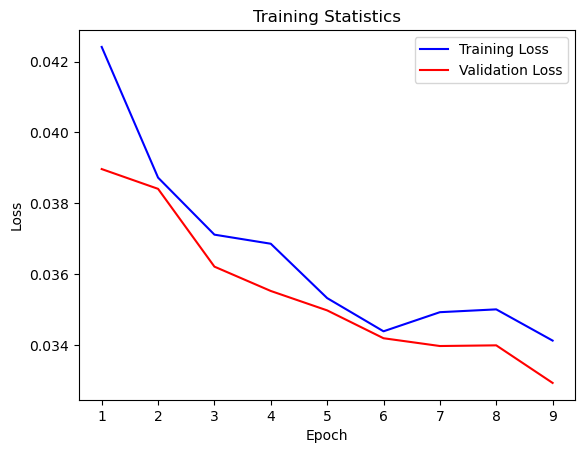

In [26]:
from importlib import reload
import src.wnet as wnet
import src.network as network
import src.loss as loss
loss = reload(loss)
network = reload(network)
wnet = reload(wnet)

net = wnet.WNet(device_type=device)
net.to(device)

net.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=30,
    learn_rate=1e-3,
    weight_decay=1e-5
)

In [5]:
date = datetime.now().__str__()
date = date[:16].replace(':', '-').replace(' ', '-')
torch.save({
            'epoch': 20,
            'model_state_dict': net.state_dict(),
            }, f'models/wnet-{date}.pt')

In [22]:
import utils.visualize as visualize
from src.crf import crf_fit_predict, crf_batch_fit_predict
for i,batch in enumerate(X_test):
  if i < 1:
    k = 1
    inputs = batch
    mask, outputs = net.forward(inputs)
    inputs = inputs.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()
    crf_mask = crf_batch_fit_predict(mask, inputs)
    

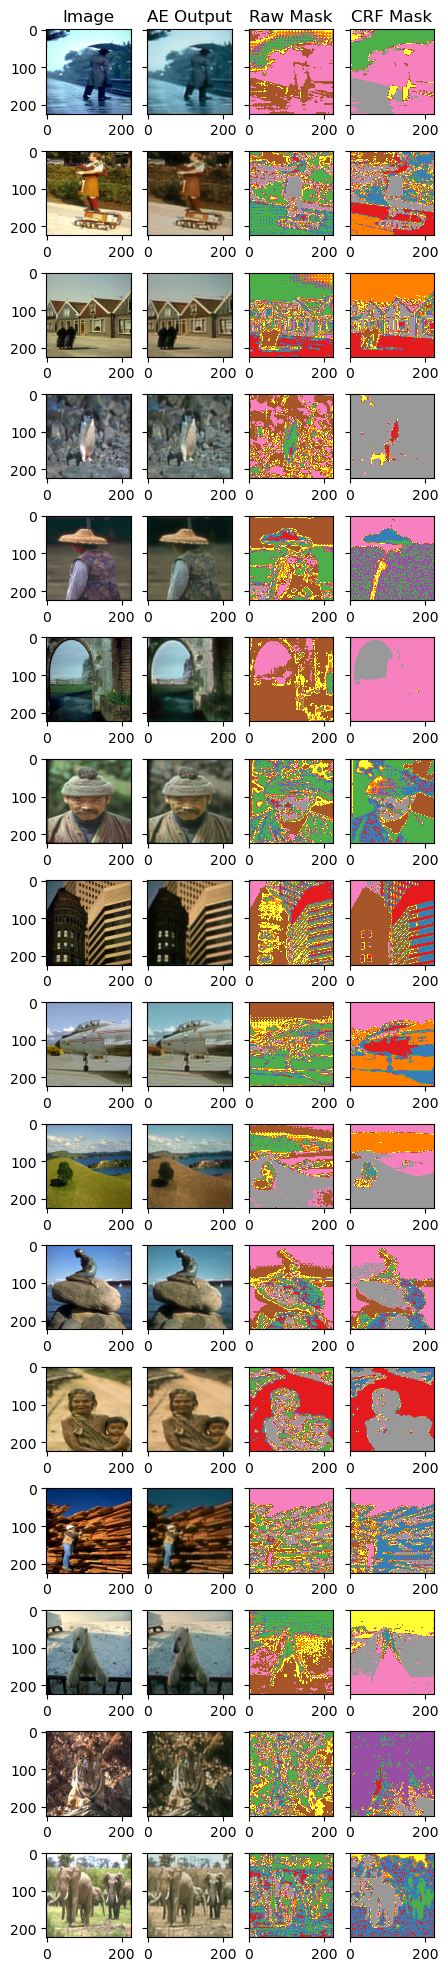

In [23]:
visualize = reload(visualize)
visualize.visualize_outputs(inputs, outputs, mask.argmax(1), crf_mask.argmax(1),
                      titles=['Image', 'AE Output', 'Raw Mask', 'CRF Mask'])